## Introduction

The goal of this project is to utilize dimensionality reduction on a dataset with a large set of features, and then fit our data to both a Random Forest Classification algorithm and a Support Vector Machine Classification algorithm. During our process we will load the data, split the data into validation and test sets, and then visualize and make predictions on the data. Our first step below will be importing packages.

**Imports**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data Preparation & Visualization

**Helper Functions**

We will first create a helper function for loading the data into a Pandas DataFrame, and then splitting the data into validation and test sets. For our validation and test size, I am opting to have 15% of the data as the validation set and 15% of the data as the test set. This leaves 70% of the data as our training set.

In [2]:
def load_and_split_data(filename):
    
    data = pd.read_csv(filename)
    X = data.drop("label", axis = 1)
    y = data.label
    
    Xtrain, Xval, ytrain, yval = train_test_split(X, y,  test_size = .30, random_state = 42)
    Xtest, Xval, ytest, yval = train_test_split(Xval, yval, test_size = .50, random_state = 42)
    
    return Xtrain, Xval, Xtest, ytrain, yval, ytest

In [3]:
Xtrain, Xval, Xtest, ytrain, yval, ytest = load_and_split_data("train.csv")
#Load data and split into train, validation, and test sets. We will put validation and test sets to the side.

With the data loaded let's take a look at our labels for our y variable, which will be numbers 0-9. We can visualize this using the countplot in seaborn. We want to only look at our training data to avoid any potential bias from seeing our test or validation sets.

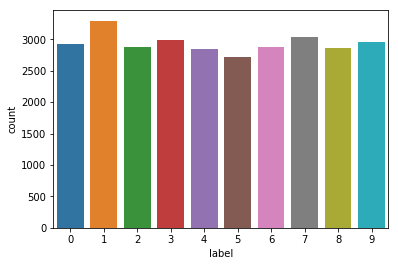

In [4]:
sb.countplot(ytrain)

As we can see in the above plot, we have similar counts for each label in our y variable. This is helpful as we do not have any lopsided data.

**Summarize Data**

Next, we want to look at the summary of our data to get an insight of what we are working with. Then we will want to check for null values.

In [5]:
Xtrain.describe()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,29400.0,...,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.000000,29400.0,29400.0,29400.0,29400.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.213980,0.115272,0.069728,0.028469,0.019388,0.004082,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.354561,4.467579,3.651858,2.102425,2.078635,0.495138,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.000000,254.000000,62.000000,0.0,0.0,0.0,0.0


Looking at the above table, a lot of these pixels are equal to zero. Meaning that most of these pixels are just blackspace, and therefore mostly meaningless. We will visualize some of data points to see the true image that the pixels represent. However, we will want to check out the null values first to make sure none of our images are corrupted or missing pixels.

In [6]:
Xtrain.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [7]:
Xval.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
Xtest.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

As we can see above, there are no null values in our training, validation, or test set. Therefore, we do not have to worry about any data imputation methods and can move forward on this data.

**Normalization**

Since our data is in grayscale (pixels range from 0-255.0), we will want to perform grayscale normalization to make our data be in a range that is more "normal" to our senses and reduce image distraction.

In [9]:
Xtrain, Xval, Xtest = Xtrain / 255.0, Xval / 255.0, Xtest / 255.0

**Visualize Data**

In order to visualize some of our data to get an idea of the image these pixels form, we will want to reshape our data to a 28px x 28px image. Since we do not want to reshape our actual training data, we will make a copy of the data and reshape that. We will then visualize the first 3 images of our training set.

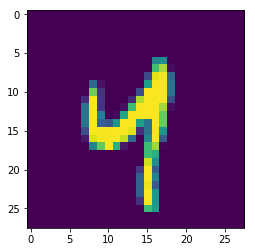

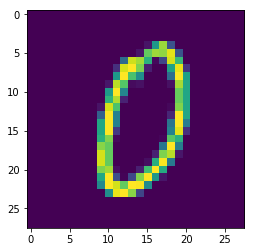

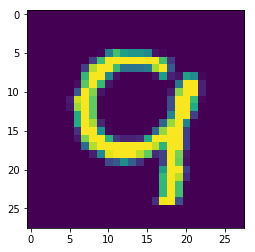

In [10]:
Xtrain_copy = Xtrain.copy()
Xtrain_reshaped = Xtrain_copy.values.reshape(-1, 28, 28)

for i in range(0, 3):
    plt.imshow(Xtrain_reshaped[i][:, :])
    plt.show()

**Dimensionality Reduction**

Our next step in preparing the data is to perform dimensionality reduction. As noted above, most pixels included in our dataset our blackspace and therefore unneeded. We will want to plot the explained variance as a function of dimensions to get an idea of the number of dimensions where the explained variance starts to taper off. 

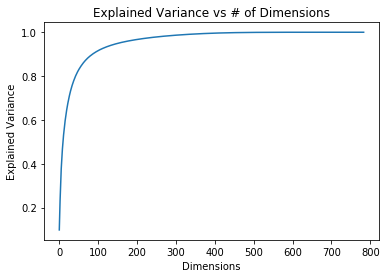

In [11]:
pca = PCA()
pca.fit(Xtrain)
Xtrain_cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(Xtrain_cumsum)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.title("Explained Variance vs # of Dimensions")
plt.show()

We can see from the plot above that the curve starts to taper off right around the .92-.95 level, so we will choose our "n" number of components to be the explained variance ratio of .95. 

In [12]:
pca_final = PCA(n_components=.95)
Xtrain_reduced = pca_final.fit_transform(Xtrain)
print("Number of dimensions before: {0}".format(Xtrain.shape[1]))
print("Number of dimensions after: {0}".format(Xtrain_reduced.shape[1]))

Number of dimensions before: 784
Number of dimensions after: 153


So, keeping an explained variance ratio of .95 we have drastically reduced the number of dimensions in this dataset from 784 to 153. We will want to reduce the dimensions on our validation and test set now.

In [13]:
Xval_reduced = pca_final.transform(Xval)
Xtest_reduced = pca_final.transform(Xtest)
print("Number of dimensions in validation set: {0}".format(Xval_reduced.shape[1]))
print("Number of dimensions in test set: {0}".format(Xtest_reduced.shape[1]))

Number of dimensions in validation set: 153
Number of dimensions in test set: 153


As we can see above, transforming the validation and test set to our PCA algorithm that we fit on the training data reduced their dimensions to 153 as well. With this taken care of, we are now ready for fitting our reduced data to our chosen algorithms of Random Forest Classifier and Support Vector Machine Classifier.

## Model Fitting

**Random Forest Classifier**

Our first model we will fit will be the Random Forest Classification model. We will first fit the model on default parameters, check the performance to get an idea of how Random Forest Classification performs on this data, and then fit the model using GridSearchCV. GridSearchCV tries out all variations of given parameters, and evaluates the models performance using, in our case, five-fold cross validation. We will choose the model that performs best on cross validation.

In [14]:
rfc = RandomForestClassifier()
rfc.fit(Xtrain_reduced, ytrain)
print("Cross Validated Accuracy: {0}".format(np.mean(cross_val_score(rfc, Xtrain_reduced, ytrain, cv = 5))))

Cross Validated Accuracy: 0.8602034238279039


So, for the base Random Forest Classification model we get an average cross-validated accuracy score of about .862. While this is good, I believe we can do better, so we will utilize GridSearchCV as noted above.

In [15]:
"""search_params = {
                    "n_estimators": [100, 200, 250, 400, 500],
                    "max_depth": [1, 2, 4, 16, 32, 64]
                }

rfc_gs = GridSearchCV(RandomForestClassifier(), param_grid=search_params, scoring = "accuracy", cv = 5)
rfc_gs.fit(Xtrain_reduced, ytrain)"""

'search_params = {\n                    "n_estimators": [100, 200, 250, 400, 500],\n                    "max_depth": [1, 2, 4, 16, 32, 64]\n                }\n\nrfc_gs = GridSearchCV(RandomForestClassifier(), param_grid=search_params, scoring = "accuracy", cv = 5)\nrfc_gs.fit(Xtrain_reduced, ytrain)'

In [16]:
"""gs_results = rfc_gs.cv_results_
joblib.dump(rfc_gs, "rfc_gridsearch")

for mean_test_score, params in zip(gs_results["mean_test_score"], gs_results["params"]):
    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))"""

'gs_results = rfc_gs.cv_results_\njoblib.dump(rfc_gs, "rfc_gridsearch")\n\nfor mean_test_score, params in zip(gs_results["mean_test_score"], gs_results["params"]):\n    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))'

In [17]:
rfc_gs = joblib.load("rfc_gridsearch_comp.gz")
gs_results = rfc_gs.cv_results_

for mean_test_score, params in zip(gs_results["mean_test_score"], gs_results["params"]):
    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))

Mean Accuracy : 0.5471428571428572   Params: {'max_depth': 1, 'n_estimators': 100}
Mean Accuracy : 0.5711224489795919   Params: {'max_depth': 1, 'n_estimators': 200}
Mean Accuracy : 0.574047619047619   Params: {'max_depth': 1, 'n_estimators': 250}
Mean Accuracy : 0.5804761904761905   Params: {'max_depth': 1, 'n_estimators': 400}
Mean Accuracy : 0.5770068027210884   Params: {'max_depth': 1, 'n_estimators': 500}
Mean Accuracy : 0.6835374149659864   Params: {'max_depth': 2, 'n_estimators': 100}
Mean Accuracy : 0.6906462585034013   Params: {'max_depth': 2, 'n_estimators': 200}
Mean Accuracy : 0.7035374149659864   Params: {'max_depth': 2, 'n_estimators': 250}
Mean Accuracy : 0.7053061224489796   Params: {'max_depth': 2, 'n_estimators': 400}
Mean Accuracy : 0.7047278911564626   Params: {'max_depth': 2, 'n_estimators': 500}
Mean Accuracy : 0.805374149659864   Params: {'max_depth': 4, 'n_estimators': 100}
Mean Accuracy : 0.8073469387755102   Params: {'max_depth': 4, 'n_estimators': 200}
Mean A

As we can see above, we have multiple models that were created through the grid search. Since our mean accuracy represents the mean cross-validated accuracy, we will want to choose the model with the highest mean accuracy. The model with parameters 'max_depth' = 32, and 'n_estimators' = 500 gives us a mean accuracy of .9419, which is the highest. In other terms, our best model is with a max tree depth of 32, and a total of 500 trees in the forest. We will now want to save our best model, as well as dump the model for future use.

In [18]:
best_rfc_mod = rfc_gs.best_estimator_
joblib.dump(best_rfc_mod, "best_rfc_model")

['best_rfc_model']

With our model now saved, we will now want to move on from Random Forest Classification and introduce Support Vector Machine Classification.

**Support Vector Machine Classifier**

For this model, we will do similar steps taken for the Random Forest Classifier. We will first fit a model to get an idea of what to expect from this algorithm, and then we will utilize GridSearchCV to get cross-validated accuracy scores from numerous models and use those scores to select our best model.

In [19]:
svc = SVC()
svc.fit(Xtrain_reduced, ytrain)
print("Cross Validated Accuracy: {0}".format(np.mean(cross_val_score(svc, Xtrain_reduced, ytrain, cv = 5))))

Cross Validated Accuracy: 0.9602041896982699


For our base model of the Support Vector Machine Classification algorithm we get a cross-validated mean accuracy of about .960. This is a already better than our best model of the Random Forest Classifier, but we will still utilize GridSearchCV to see if we can find a better performing model.

In [20]:
"""search_params2 = {
                    "C" : [0.01, 0.1, 1, 10, 100],
                    "kernel" : ['linear', 'poly', 'rbf', 'sigmoid']
                }
svc_gs = GridSearchCV(SVC(), param_grid=search_params2, scoring = "accuracy", cv = 5)
svc_gs.fit(Xtrain_reduced, ytrain)"""

'search_params2 = {\n                    "C" : [0.01, 0.1, 1, 10, 100],\n                    "kernel" : [\'linear\', \'poly\', \'rbf\', \'sigmoid\']\n                }\nsvc_gs = GridSearchCV(SVC(), param_grid=search_params2, scoring = "accuracy", cv = 5)\nsvc_gs.fit(Xtrain_reduced, ytrain)'

In [21]:
"""gs_results2 = svc_gs.cv_results_
joblib.dump(svc_gs, "svc_gridsearch")

for mean_test_score, params in zip(gs_results2["mean_test_score"], gs_results2["params"]):
    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))"""

'gs_results2 = svc_gs.cv_results_\njoblib.dump(svc_gs, "svc_gridsearch")\n\nfor mean_test_score, params in zip(gs_results2["mean_test_score"], gs_results2["params"]):\n    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))'

In [22]:
svc_gs = joblib.load("svc_gridsearch_comp.gz")
gs_results2 = svc_gs.cv_results_

for mean_test_score, params in zip(gs_results2["mean_test_score"], gs_results2["params"]):
    print("Mean Accuracy : {0}   Params: {1}".format(mean_test_score, params))

Mean Accuracy : 0.9335034013605442   Params: {'C': 0.01, 'kernel': 'linear'}
Mean Accuracy : 0.11210884353741496   Params: {'C': 0.01, 'kernel': 'poly'}
Mean Accuracy : 0.8641496598639455   Params: {'C': 0.01, 'kernel': 'rbf'}
Mean Accuracy : 0.830204081632653   Params: {'C': 0.01, 'kernel': 'sigmoid'}
Mean Accuracy : 0.9381292517006803   Params: {'C': 0.1, 'kernel': 'linear'}
Mean Accuracy : 0.3871428571428571   Params: {'C': 0.1, 'kernel': 'poly'}
Mean Accuracy : 0.9323469387755102   Params: {'C': 0.1, 'kernel': 'rbf'}
Mean Accuracy : 0.9072108843537415   Params: {'C': 0.1, 'kernel': 'sigmoid'}
Mean Accuracy : 0.9314285714285714   Params: {'C': 1, 'kernel': 'linear'}
Mean Accuracy : 0.9158843537414966   Params: {'C': 1, 'kernel': 'poly'}
Mean Accuracy : 0.960204081632653   Params: {'C': 1, 'kernel': 'rbf'}
Mean Accuracy : 0.9284013605442177   Params: {'C': 1, 'kernel': 'sigmoid'}
Mean Accuracy : 0.9252380952380952   Params: {'C': 10, 'kernel': 'linear'}
Mean Accuracy : 0.970238095238

As we can see above, we have multiple models that were created through the grid search. Since our mean accuracy represents the mean cross-validated accuracy, we will want to choose the model with the highest mean accuracy. The model with parameters 'C' = 100, and 'Kernel' = 'poly' gives us a mean accuracy of about .978, which is the highest. In other terms, our best model is with a C of 100, and a Kernel of 'poly'. We will now want to save our best model, as well as dump the model for future use.

In [23]:
best_svc_mod = svc_gs.best_estimator_
joblib.dump(best_svc_mod, "best_svc_model")

['best_svc_model']

With our model now saved, we will now want to move on from definining our initial models and best models and use our validation data to see which model performs best. We will then use our best performing model as our final model, and see how this model performs on our last unseen data which is the test set.

## Model Evaluation

**Predictions and Final Model Selection with Validation Data**

In [27]:
rfc_pred = best_rfc_mod.predict(Xval_reduced)
svc_pred = best_svc_mod.predict(Xval_reduced)

rfc_acc = accuracy_score(yval, rfc_pred)
svc_acc = accuracy_score(yval, svc_pred)

print("Accuracy of Random Forest Classifier Model on Validation data: {0} \nAccuracy of Support Vector Machine Classifier Model on Validation data: {1}".format(rfc_acc, svc_acc))

Accuracy of Random Forest Classifier Model on Validation data: 0.9453968253968253 
Accuracy of Support Vector Machine Classifier Model on Validation data: 0.9796825396825397


As we can see above, our best model is the model chosen from GridSearchCV on the Support Vector Machine Classification Algorithm with C = 100 and Kernel = 'poly'. This model outperforms our best chosen Random Forest Classification model on the validation set, so we will use this model for the remainder of this project.

**Predictions on Test Data With Final Model and Visualization of Predictions & Prediction Errors**

Now that we have decided that our Support Vector Machine Classifier model is our best model through validation data, we will use this model to make predictions on our final dataset (test data) and then take a look at the accuracy and confusion matrix. The confusion matrix shows us the total number of correctly predicted and incorrectly predicted points in our data set.

In [28]:
final_predicts = best_svc_mod.predict(Xtest_reduced)
final_accuracy = accuracy_score(ytest, final_predicts)
print("Accuracy on Test Data: {0}".format(final_accuracy))

Accuracy on Test Data: 0.9804761904761905


We can see that our model performs almost identical on all three datasets, so we know that our model was not overfitting. We get an accuracy of .9804 on our test data, which is very good. We will now take a look at the confusion matrix to see where our model is misclassifying the most.

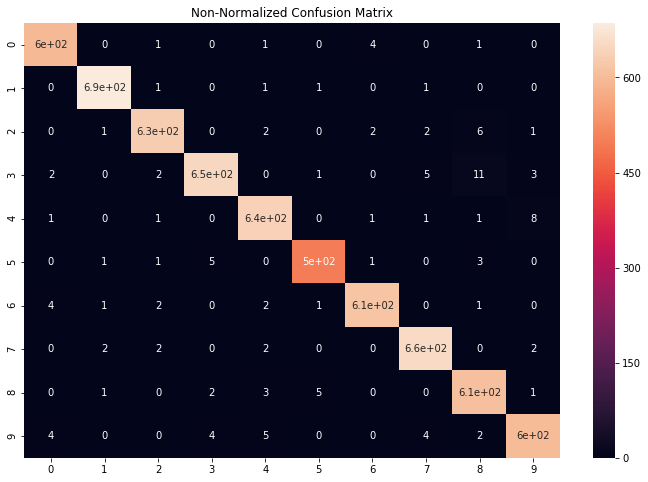

In [29]:
conf_matrx = confusion_matrix(ytest, final_predicts)
conf_matrx_df = pd.DataFrame(conf_matrx, index = [i for i in range(10)],
                  columns = [i for i in range(10)])
plt.figure(figsize = (12, 8))
sb.heatmap(conf_matrx_df, annot = True)
plt.title("Non-Normalized Confusion Matrix")
plt.show()

As we can see in the confusion matrix, with the given heatmap, we really do not have a large amount of misclassifications. The diaganol represents the data points that were correctly predicted, where anywhere else represents misclassifications. These misclassifications include errors such as mistaking an "8" for a "3", which is commonly done by humans themselves. Overall, I believe this model does a great job at correctly classifying each handwritten number in the test data.

## Predict on Kaggle Test Set

Kaggle.com MNIST competition includes an extra test data set to predict classes for, but we cannot calculate any prediction errors or accuracy. We will predict all classes in this data and then write it to a CSV for upload.

In [30]:
kaggle_test = pd.read_csv("test.csv")
kaggle_test = kaggle_test / 255.0
kaggle_test_reduced = pca_final.transform(kaggle_test)
print("Number of dimensions in Kaggle test set: {0}".format(kaggle_test_reduced.shape[1]))
kaggle_predictions = best_svc_mod.predict(kaggle_test_reduced)

Number of dimensions in Kaggle test set: 153


In [31]:
kaggle_output = pd.DataFrame()
kaggle_output["ImageId"] = range(1, len(kaggle_test) + 1)
kaggle_output["Label"] = kaggle_predictions
kaggle_output.to_csv("KaggleTestPredictions.csv", index = False)
print("First few predictions:\n{0}".format(kaggle_output[:5]))

First few predictions:
   ImageId  Label
0        1      2
1        2      0
2        3      9
3        4      9
4        5      3


## Conclusion

**Recap**

To Recap this project, we split the data into training, validation, and test sets. We then viewed the data, checked for discrepancies, and normalized the data. We then utilized principal component analysis to reduce the number of features (dimensionalities). Using our reduced data, we fit models using Random Forest Classification and Support Vector Machine Classification and then utilized GridSearch and Cross-Validation to choose our best model on the training data. With our best model chosen, we then chose our final model using validation data and then evaluated our final model on our testing data and looked at where our model was making the most errors. Lastly, we predicted classes for our test data set from Kaggle.com.

**Conclusion**

Our final model had an accuracy of .981, and can be considered a very useful model.